# Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Data (preprocess)

In [ ]:
# lock_meas = '..\\..\\DATA\\RAW\\Measure_02' # Location folder of the measurement files
file_list = os.listdir(lock_meas)           # Make a list out of the files in the folder
nb_meas = len(file_list)/4                  # Every measurement contains 4 file (IMU, MoCap, Robotino, NFO)

meas_list = []                              # Make a list containing the independent measurements
for FILE_NAME in file_list:
    meas_list.append(FILE_NAME[0:22])       # The unique ID is the time, the first 22 character
meas_list = list(set(meas_list))

# Load in one favourite measurement block
meas_id = 4

# Syncronise the measurement files from MoCap and IMU
if meas_id>(nb_meas-1):
    meas = 0
meas_date = str(meas_list[meas_id])

# Load the IMU csv data file
imu_data = pd.read_csv(lock_meas + '\\' + meas_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

# Load the MoCap csv data file
mocap_data = pd.read_csv(lock_meas + '\\' + meas_date + 'MoCap.txt',
                                 sep='\t',
                                 decimal=',',
                                 names=['time', 'x', 'y', 'z', 'tracked', 'beta', 'Qx', 'Qy', 'Qz', 'Qw'])

# Merge the two data file to synronise them. In both dataset there are some data row that can't be matched, this data will
# be trown away
data = pd.merge(imu_data, mocap_data, on=['time'], how='inner')

# ===== Filters ======

# When the magneto sensors values are [0, 0, 0] that is a false value. These rows are deleted.
# When tacked is 0, it is indicates that the MoCap data is invalid. These rows are deleted too.
df = data[~(data[['mag0','mag1','mag2','tracked']] == 0).any(axis=1)]
# From now on the tracked column can be deleted, because it contains only 1s.
del df['tracked']
# Add to more columns to make a fluent orientation function (orient) and a delta time (deltat)
df = df.assign(orient=0)
df = df.assign(deltat=0)
df = df.assign(level=0)
# Convert the data frame into numpy array
dfarray = np.array(df)
# Create a lookup table to make the use of this matrix more readable.
time   = 0
acc0   = 1
acc1   = 2
acc2   = 3
gyro0  = 4
gyro1  = 5
gyro2  = 6
mag0   = 7
mag1   = 8
mag2   = 9
x      = 10
y      = 11
z      = 12
beta   = 13
Qx     = 14
Qy     = 15
Qz     = 16
Qw     = 17
orient = 18
deltat = 19
level  = 20

# Calculate the delta time between two valid measurements
for i in range(dfarray.shape[0]):
    if (i-1)>-1:
        dfarray[i,deltat] = dfarray[i,time]-dfarray[i-1,time]

# Creating a more fluent orientation function
level = 0
for i in range(dfarray.shape[0]):
    if (i-1)>-1:
        if (dfarray[i,beta]-dfarray[i-1,beta])>355:
            level = level - 1
        if (dfarray[i,beta]-dfarray[i-1,beta])<-355:
            level = level + 1
        else:
            level = level   
        dfarray[i, orient] = level*360 + dfarray[i, beta]

# Statistics

In [105]:
df.head(5)

time   acc0   acc1   acc2  gyro0  gyro1  gyro2   mag0   mag1   mag2  \
2  181708.0690  0.005 -0.054  1.025 -0.624  0.000 -0.027 -0.388 -0.139  0.076   
3  181708.0781  0.004 -0.053  1.025 -1.007  0.181  0.134 -0.388 -0.136  0.079   
4  181708.0870  0.005 -0.054  1.025 -0.846  0.322 -0.188 -0.388 -0.136  0.076   
8  181708.1229  0.004 -0.054  1.025 -0.987  0.081 -0.161 -0.388 -0.136  0.076   
9  181708.1338  0.004 -0.052  1.025 -0.685  0.000 -0.255 -0.388 -0.139  0.079   

   ...        y      z    beta     Qx     Qy     Qz    Qw  orient  deltat  \
2  ...    0.222  1.067  46.220  0.006 -0.392  0.007  0.92       0       0   
3  ...    0.222  1.067  46.229  0.006 -0.393  0.007  0.92       0       0   
4  ...    0.222  1.067  46.234  0.006 -0.393  0.007  0.92       0       0   
8  ...    0.222  1.067  46.216  0.006 -0.392  0.007  0.92       0       0   
9  ...    0.222  1.067  46.220  0.006 -0.392  0.007  0.92       0       0   

   level  
2      0  
3      0  
4      0  
8      0  
9      0  

[5 rows x 21 columns]

In [14]:
len(df)

1371

# Graphs

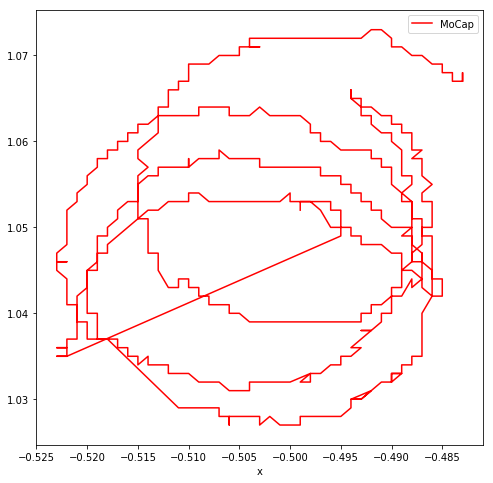

In [15]:
df.plot(x='x', y='z', color='red', figsize=(8,8), label='MoCap')

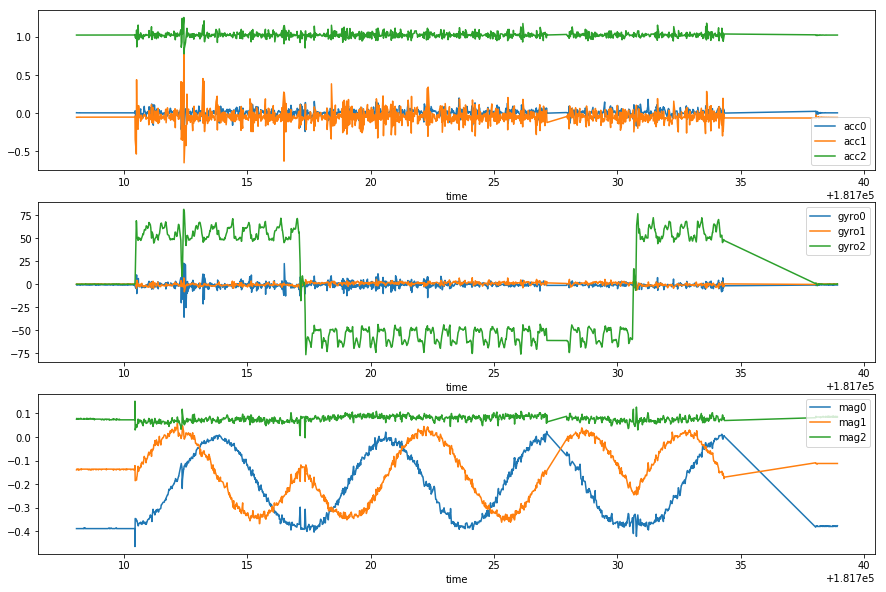

In [16]:
f1, (ax1, ax2, ax3) = plt.subplots(3, 1)
df.plot(x='time', y='acc0', figsize=(15,10), ax=ax1)
df.plot(x='time', y='acc1', ax=ax1)
df.plot(x='time', y='acc2', ax=ax1)
df.plot(x='time', y='gyro0', ax=ax2)
df.plot(x='time', y='gyro1', ax=ax2)
df.plot(x='time', y='gyro2', ax=ax2)
df.plot(x='time', y='mag0', ax=ax3)
df.plot(x='time', y='mag1', ax=ax3)
df.plot(x='time', y='mag2', ax=ax3)

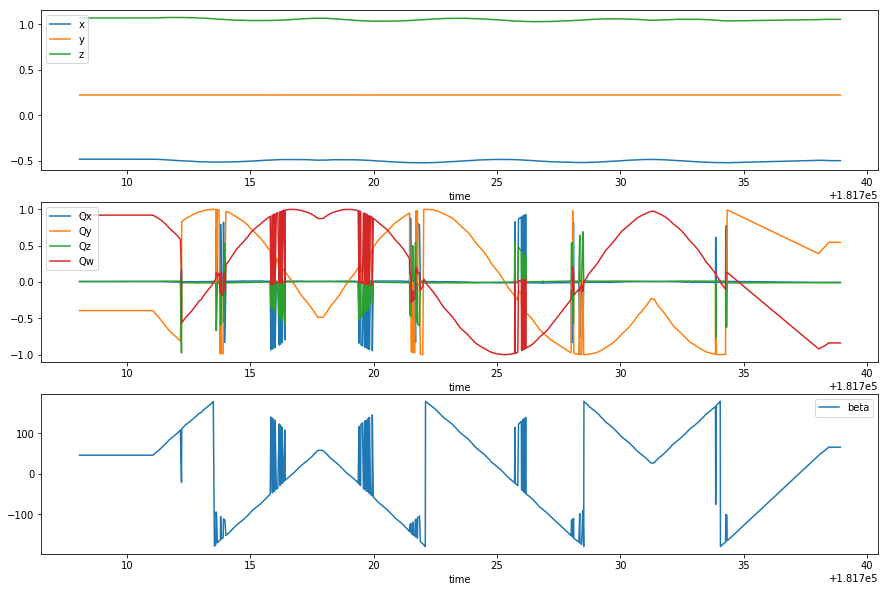

In [19]:
f2, (ax4, ax5, ax6) = plt.subplots(3, 1)
df.plot(x='time', y='x', figsize=(15,10), ax=ax4)
df.plot(x='time', y='y', ax=ax4)
df.plot(x='time', y='z', ax=ax4)
df.plot(x='time', y='Qx', ax=ax5)
df.plot(x='time', y='Qy', ax=ax5)
df.plot(x='time', y='Qz', ax=ax5)
df.plot(x='time', y='Qw', ax=ax5)
df.plot(x='time', y='beta', ax=ax6)

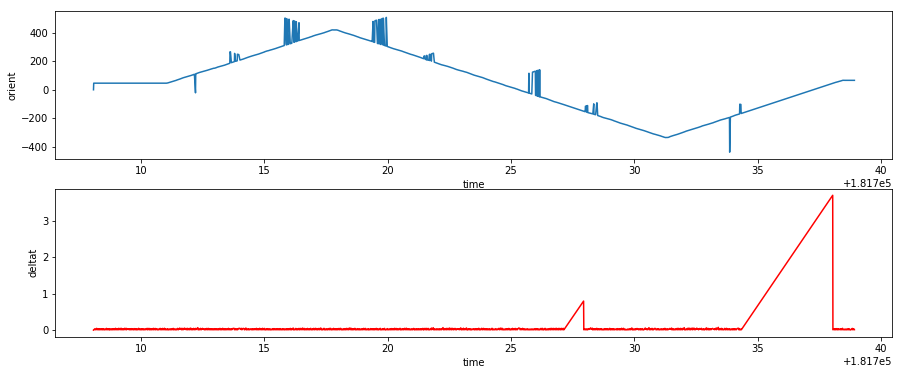

In [131]:
plt.figure(figsize=(15,6))
# equivalent but more general
ax1=plt.subplot(2, 1, 1)
ax1=plt.plot(dfarray[:,time],dfarray[:,orient])
plt.xlabel('time')
plt.ylabel('orient')

ax2=plt.subplot(212)
ax2=plt.plot(dfarray[:,time],dfarray[:,deltat], color="red")
plt.xlabel('time')
plt.ylabel('deltat')

plt.show()